In [1]:
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_helper import rel_slicer
from PW_explorer.time_series import PWETimeSeriesModule
from PW_explorer.pwe_nb_helper import ASPRules
from PW_explorer.export import PWEExport
from PW_explorer.visualize import PWEVisualization

import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
from copy import deepcopy
from collections import OrderedDict
from matplotlib import pylab

In [2]:
%load_ext PWE_NB_Extension

In [3]:
dataValues = [['"Sun"','"big"','1'],['"Planet"','"medium"','8'],['"Moon"','"small"','2']]
clingo_rules = ['% schema data(ENDTYPE,ENDSIZE,ENDPOPULATION,COLOUR,TRANS,TYPE,SIZE,POPULATION)']

In [4]:
def turn_list_into_str(l):
    # small bug fix 
    if isinstance(l, (list,set,frozenset)):
        if len(l) > 1:
            l_ = [turn_list_into_str(l1) for l1 in l[1:]]
            return "{}({})".format(l[0], ",".join(l_))
        elif len(l) == 1:
            return "{}".format(l[0])
        else:
            return ""
    else:
        return l


In [5]:
def makeOriginal(dataValues,colour='black'):
    clingoStart = 'data('
    for i,x in enumerate(dataValues):
        clingoStart += 'row'+str(i)+'('+','.join(x)+'),'
    clingoStart = clingoStart[:-1] 
    clingoStart += ').'
    return clingoStart

In [6]:
originalSetup = makeOriginal(dataValues)

In [7]:
originalSetup

'data(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)).'

In [8]:
ASPRules(originalSetup)

'data(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)).'

In [9]:
def addConversion(dataValues):
    variableList = []
    for y in range(len(dataValues)):
        variableList.append([chr(65+x+(y*len(dataValues[0]))) for x in range(len(dataValues[y]))]) # all rows must be of the same length
    clingoHead = 'data(row0('
    clingoBody = 'e(data(row0('
    for x in range(len(variableList)):
        clingoHead += ','.join(variableList[x])
        clingoBody += ','.join(variableList[x])
        if x != len(variableList) -1:
            clingoHead += '), row'+str(x+1)+'('
            clingoBody += '), row'+str(x+1)+'('
        else:
            clingoHead += ')) :- '
            clingoBody += ')),data(row0(_,_,_), row1(_,_,_), row2(_,_,_)),trans(_,_)).'
    
    return clingoHead+clingoBody

In [10]:
edgeNodeConv = addConversion(dataValues)

In [11]:
ASPRules(edgeNodeConv)

'data(row0(A,B,C), row1(D,E,F), row2(G,H,I)) :- e(data(row0(A,B,C), row1(D,E,F), row2(G,H,I)),data(row0(_,_,_), row1(_,_,_), row2(_,_,_)),trans(_,_)).'

In [12]:
def makeSelect(dataValues,colour='orange'):
    # currently still only row by row for the toy dataset, multi row selects can be included fairly easily though
    # just add another loop and block out fewer rows
    # not needed right now as now rows share values
    clingoStart = ''
    variableList = []
    variableList2 = []
    dataValTotLength = len(dataValues[0])*len(dataValues)
    for y in range(len(dataValues)):
        variableList.append([chr(65+x+(y*len(dataValues[0]))) for x in range(len(dataValues[y]))]) # all rows must be of the same length
        variableList2.append([chr(65+dataValTotLength+x+(y*len(dataValues[0]))) for x in range(len(dataValues[y]))]) # all rows must be of the same length

    clingoStart =  []
    variString = 'row0('
    for x in range(len(variableList)):
        variString += ','.join(variableList[x])
        if x != len(variableList) -1:
            variString += '), row'+str(x+1)+'('
        else:
            variString += ')'

    #variString = ','.join(variables)
    for dataVal in dataValues:
        for x in range(len(variableList)):
            for y in range(len(variableList[x])):
                start = y
                end = y+x+1
                if end > len(variableList[x]):
                    end += -len(variableList[x])-1
                    templistvar = variableList[x][end:end+1]
                    templistvar.extend(variableList[x][start:])
                    templistdataVal = dataVal[end:end+1]
                    templistdataVal.extend(dataVal[start:])
                else:
                    templistvar = variableList[x][start:end]
                    templistdataVal = dataVal[start:end]
                listcomp = [v+'='+d+',' for v,d in zip(templistvar,templistdataVal)]
                
                newDataValues = [] # define arbitrary start values
                for i,z in enumerate(variableList[x]):
                    if z in templistvar:
                        newDataValues.append(z)
                    else:
                        newDataValues.append(chr(65+dataValTotLength+(len(variableList[x])*x)+i))
                
                finalVariString = 'row0('
                finalVariStringEnd = 'row0('
                arbStartValues = 'row0('
                for z in range(len(variableList)):
                    if z != x:
                        arbStartValues += ','.join(variableList2[z])
                        finalVariString += ','.join(['"-"']*len(variableList[z]))
                        finalVariStringEnd += ','.join(['_']*len(variableList[z]))
                    else:
                        arbStartValues += ','.join(newDataValues)
                        finalVariString += ','.join(variableList[z])
                        finalVariStringEnd += ','.join(variableList[z])
                    if z != len(variableList) -1 :
                        arbStartValues += '),row'+str(z+1)+'('
                        finalVariString += '),row'+str(z+1)+'('
                        finalVariStringEnd += '),row'+str(z+1)+'('
                    else:
                        arbStartValues += ')'
                        finalVariString += ')'
                        finalVariStringEnd += ')'
                #arbStartValues = ','.join(newDataValues)
                
                finalStringOG = "".join(listcomp)
                finalString = finalStringOG[:-1] +'.'
                finalStringOG = finalStringOG.replace('"','')
                finalStringOG = finalStringOG.replace(',','-')
                finalStringOG += '",'
                clingoStart.append('e(data('+finalVariString+'),data('+arbStartValues+'),trans("'+finalStringOG+colour+')) :- data('+finalVariStringEnd+'),data('+arbStartValues+'),'+finalString) 
    return clingoStart

In [13]:
selectCommands = makeSelect(dataValues) # may contain dupliucates

In [14]:
ASPRules('\n'.join(selectCommands))

'e(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),trans("A=Sun-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),A="Sun".\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),trans("B=big-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),B="big".\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),trans("C=1-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),C=1.\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),trans("D=Sun-E=big-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),D="Sun",E="big".\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),trans("E=big-F=1-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),E="big",F=1.\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),trans("D=Sun-F=1-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),D="Sun",F=1.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=Sun-H=big-I=1-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G="Sun",H="big",I=1.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=Sun-H=big-I=1-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G="Sun",H="big",I=1.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(P,H,I)),trans("H=big-I=1-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(P,H,I)),H="big",I=1.\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),trans("A=Planet-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),A="Planet".\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),trans("B=medium-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),B="medium".\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),trans("C=8-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),C=8.\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),trans("D=Planet-E=medium-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),D="Planet",E="medium".\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),trans("E=medium-F=8-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),E="medium",F=8.\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),trans("D=Planet-F=8-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),D="Planet",F=8.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=Planet-H=medium-I=8-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G="Planet",H="medium",I=8.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=Planet-H=medium-I=8-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G="Planet",H="medium",I=8.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L)

In [15]:
def makeProject(dataValues,colour='red'):
    # right now only removes one column, remove N-1 later
    clingoStart = []
    variableList = []
    for y in range(len(dataValues)):
        variableList.append([chr(65+x+(y*len(dataValues[0]))) for x in range(len(dataValues[y]))]) # all rows must be of the same length
    variString = 'data(row0('
    for y in range(len(variableList)):
        variString += ','.join(variableList[y])
        if y != len(variableList) -1:
            variString += '),row'+str(y+1)+'('
        else:
            variString += ')'
    #variString = ','.join(variables)
    
    
    for loop in range(len(variableList[0])-1):
        for x in range(len(variableList[0])):
            clingoString = 'data(row0('
            for i,variables in enumerate(variableList):
                newVariables = [x for x in variables]
                otherNewVariables = [x for x in variables]
                start = x
                end = x + loop +1
                if end > len(variables)-1:
                    end += - len(variables)
                    donotRemove = [val for val in range(end,start)]
                    removeKeys = [val for val in range(len(variables)) if val not in donotRemove]
                    strdonotRemove = [str(val) for val in donotRemove]
                    donotRemoveString = '-'.join(strdonotRemove)
                else:
                    removeKeys = [val for val in range(start,end)]
                    donotRemove = [str(val) for val in range(len(variables)) if val not in removeKeys]
                    donotRemoveString = '-'.join(donotRemove)
                for remove in removeKeys:
                    newVariables[remove] = '_'
                    otherNewVariables[remove] = '"-"'
                newVariString = ','.join(newVariables)
                otherNewVariString = ','.join(otherNewVariables)
                clingoString += otherNewVariString
                if i != len(variableList) -1:
                    clingoString += '),row'+str(i+1)+'('
                else:
                    clingoString += '))'
            clingoStart.append('e('+clingoString+','+variString+'),trans("Pro-Col-'+donotRemoveString+'",'+colour+')) :- '+variString+').') 

    return clingoStart

In [16]:
projectCommands = makeProject(dataValues)

In [17]:
ASPRules('\n'.join(projectCommands))

'e(data(row0("-",B,C),row1("-",E,F),row2("-",H,I)),data(row0(A,B,C),row1(D,E,F),row2(G,H,I)),trans("Pro-Col-1-2",red)) :- data(row0(A,B,C),row1(D,E,F),row2(G,H,I)).\ne(data(row0(A,"-",C),row1(D,"-",F),row2(G,"-",I)),data(row0(A,B,C),row1(D,E,F),row2(G,H,I)),trans("Pro-Col-0-2",red)) :- data(row0(A,B,C),row1(D,E,F),row2(G,H,I)).\ne(data(row0(A,B,"-"),row1(D,E,"-"),row2(G,H,"-")),data(row0(A,B,C),row1(D,E,F),row2(G,H,I)),trans("Pro-Col-0-1",red)) :- data(row0(A,B,C),row1(D,E,F),row2(G,H,I)).\ne(data(row0("-","-",C),row1("-","-",F),row2("-","-",I)),data(row0(A,B,C),row1(D,E,F),row2(G,H,I)),trans("Pro-Col-2",red)) :- data(row0(A,B,C),row1(D,E,F),row2(G,H,I)).\ne(data(row0(A,"-","-"),row1(D,"-","-"),row2(G,"-","-")),data(row0(A,B,C),row1(D,E,F),row2(G,H,I)),trans("Pro-Col-0",red)) :- data(row0(A,B,C),row1(D,E,F),row2(G,H,I)).\ne(data(row0("-",B,"-"),row1("-",E,"-"),row2("-",H,"-")),data(row0(A,B,C),row1(D,E,F),row2(G,H,I)),trans("Pro-Col-1",red)) :- data(row0(A,B,C),row1(D,E,F),row2(G,H,I)).'

In [18]:
def makeJoin(dataValues,colour='blue'):
        # currently still only row by row for the toy dataset, multi row selects can be included fairly easily though
        # just add another loop and block out fewer rows
        # not needed right now as now rows share values
        clingoStart = ''
        variableList = []
        variableList2 = []
        dataValTotLength = len(dataValues[0])*len(dataValues)
        for y in range(len(dataValues)):
            variableList.append([chr(65+x+(y*len(dataValues[0]))) for x in range(len(dataValues[y]))]) # all rows must be of the same length
            variableList2.append([chr(65+dataValTotLength+x+(y*len(dataValues[0]))) for x in range(len(dataValues[y]))]) # all rows must be of the same length

        clingoStart =  []
        variString = 'row0('
        for x in range(len(variableList)):
            variString += ','.join(variableList[x])
            if x != len(variableList) -1:
                variString += '), row'+str(x+1)+'('
            else:
                variString += ')'

        #variString = ','.join(variables)
        for dataVal in dataValues:
            for x in range(len(variableList)):
                for y in range(len(variableList[x])):
                    start = y
                    end = y+x+1
                    if end > len(variableList[x]):
                        end += -len(variableList[x])-1
                        templistvar = variableList[x][end:end+1]
                        templistvar.extend(variableList[x][start:])
                        templistdataVal = dataVal[end:end+1]
                        templistdataVal.extend(dataVal[start:])
                    else:
                        templistvar = variableList[x][start:end]
                        templistdataVal = dataVal[start:end]
                    listcomp = [v+'='+d+',' for v,d in zip(templistvar,templistvar)]

                    newDataValues = [] # define arbitrary start values
                    for i,z in enumerate(variableList[x]):
                        if z in templistvar:
                            newDataValues.append(z)
                        else:
                            newDataValues.append(chr(65+dataValTotLength+(len(variableList[x])*x)+i))

                    finalVariString = 'row0('
                    finalVariStringEnd = 'row0('
                    arbStartValues = 'row0('
                    for z in range(len(variableList)):
                        if z != x:
                            arbStartValues += ','.join(variableList2[z])
                            finalVariString += ','.join(['"-"']*len(variableList[z]))
                            finalVariStringEnd += ','.join(['_']*len(variableList[z]))
                        else:
                            arbStartValues += ','.join(newDataValues)
                            finalVariString += ','.join(variableList[z])
                            finalVariStringEnd += ','.join(variableList[z])
                        if z != len(variableList) -1 :
                            arbStartValues += '),row'+str(z+1)+'('
                            finalVariString += '),row'+str(z+1)+'('
                            finalVariStringEnd += '),row'+str(z+1)+'('
                        else:
                            arbStartValues += ')'
                            finalVariString += ')'
                            finalVariStringEnd += ')'
                    #arbStartValues = ','.join(newDataValues)

                    finalStringOG = "".join(listcomp)
                    finalString = finalStringOG[:-1] +'.'
                    finalStringOG = finalStringOG.replace('"','')
                    finalStringOG = finalStringOG.replace(',','-')
                    finalStringOG += '",'
                    clingoStart.append('e(data('+finalVariString+'),data('+arbStartValues+'),trans("'+finalStringOG+colour+')) :- data('+finalVariStringEnd+'),data('+arbStartValues+'),'+finalString) 
        return clingoStart

In [19]:
joinCommands = makeJoin(dataValues)

In [20]:
ASPRules(','.join(joinCommands))

'e(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),trans("A=A-",blue)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),A=A.,e(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),trans("B=B-",blue)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),B=B.,e(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),trans("C=C-",blue)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),C=C.,e(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),trans("D=D-E=E-",blue)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),D=D,E=E.,e(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),trans("E=E-F=F-",blue)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),E=E,F=F.,e(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),trans("D=D-F=F-",blue)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),D=D,F=F.,e(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=G-H=H-I=I-",blue)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G=G,H=H,I=I.,e(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=G-H=H-I=I-",blue)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G=G,H=H,I=I.,e(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(P,H,I)),trans("H=H-I=I-",blue)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(P,H,I)),H=H,I=I.,e(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),trans("A=A-",blue)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),A=A.,e(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),trans("B=B-",blue)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),B=B.,e(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),trans("C=C-",blue)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),C=C.,e(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),trans("D=D-E=E-",blue)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),D=D,E=E.,e(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),trans("E=E-F=F-",blue)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),E=E,F=F.,e(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),trans("D=D-F=F-",blue)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),D=D,F=F.,e(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=G-H=H-I=I-",blue)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G=G,H=H,I=I.,e(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=G-H=H-I=I-",blue)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G=G,H=H,I=I.,e(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(P,H,I)),trans("H=H-I=I-",blue)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(P,H,I)),H=H,I=I.,e(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(A,K,L),row1(M,N,O),row2(P

In [21]:
clingo_rules = ['% schema row0(TYPE,SIZE,POPULATION)']
clingo_rules.extend(['% schema row1(TYPE,SIZE,POPULATION)'])
clingo_rules.extend(['% schema row2(TYPE,SIZE,POPULATION)'])
# clingo_rules = ['% schema data(row0(TYPE,SIZE,POPULATION),row1(TYPE,SIZE,POPULATION),row2(TYPE,SIZE,POPULATION))']
# clingo_rules.extend(['% schema e(data(row0(TYPE,SIZE,POPULATION),row1(TYPE,SIZE,POPULATION),row2(TYPE,SIZE,POPULATION)),data(row0(TYPE,SIZE,POPULATION),row1(TYPE,SIZE,POPULATION),row2(TYPE,SIZE,POPULATION)),trans(TRANSFORM,COLOUR))'])
clingo_rules = ['% schema data(row0,row1,row2)']
clingo_rules.extend(['% schema e(dataEnd,dataStart,trans)'])
clingo_rules.extend([originalSetup])
#clingo_rules.extend(['% schema database rules'])
clingo_rules.extend(selectCommands)
# #clingo_rules.extend(['% schema project rules'])
clingo_rules.extend(projectCommands)
#clingo_rules.extend(joinCommands)
clingo_rules.extend([edgeNodeConv])

In [22]:
ASPRules('\n'.join(clingo_rules))

'% schema data(row0,row1,row2)\n% schema e(dataEnd,dataStart,trans)\ndata(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)).\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),trans("A=Sun-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),A="Sun".\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),trans("B=big-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),B="big".\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),trans("C=1-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),C=1.\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),trans("D=Sun-E=big-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),D="Sun",E="big".\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),trans("E=big-F=1-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),E="big",F=1.\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),trans("D=Sun-F=1-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),D="Sun",F=1.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=Sun-H=big-I=1-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G="Sun",H="big",I=1.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=Sun-H=big-I=1-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G="Sun",H="big",I=1.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(P,H,I)),trans("H=big-I=1-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(P,H,I)),H="big",I=1.\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),trans("A=Planet-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),A="Planet".\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),trans("B=medium-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),B="medium".\ne(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),trans("C=8-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),C=8.\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),trans("D=Planet-E=medium-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),D="Planet",E="medium".\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),trans("E=medium-F=8-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(M,E,F),row2(P,Q,R)),E="medium",F=8.\ne(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),trans("D=Planet-F=8-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J,K,L),row1(D,N,F),row2(P,Q,R)),D="Planet",F=8.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=Planet-H=medium-I=8-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),G="Planet",H="medium",I=8.\ne(data(row0("-","-","-"),row1("-","-","-"),row2(G,H,I)),data(row0(J,K,L),row1(M,N,O),row2(G,H,I)),trans("G=Planet-H=medium-I=8-",orange)) :- data(row0(_,_,_),row1(_,_,_),row2(G,H,I

In [23]:
clingo_rules

['% schema data(row0,row1,row2)',
 '% schema e(dataEnd,dataStart,trans)',
 'data(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)).',
 'e(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),trans("A=Sun-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(A,K,L),row1(M,N,O),row2(P,Q,R)),A="Sun".',
 'e(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),trans("B=big-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,B,L),row1(M,N,O),row2(P,Q,R)),B="big".',
 'e(data(row0(A,B,C),row1("-","-","-"),row2("-","-","-")),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),trans("C=1-",orange)) :- data(row0(A,B,C),row1(_,_,_),row2(_,_,_)),data(row0(J,K,C),row1(M,N,O),row2(P,Q,R)),C=1.',
 'e(data(row0("-","-","-"),row1(D,E,F),row2("-","-","-")),data(row0(J,K,L),row1(D,E,O),row2(P,Q,R)),trans("D=Sun-E=big-",orange)) :- data(row0(_,_,_),row1(D,E,F),row2(_,_,_)),data(row0(J

In [24]:
%clingo -l clingo_rules --saveto clingo_soln --save_meta_data_to meta_data --donot-display_input

Output:


'Answer: 1\ndata(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)) data(row0("-","big",1),row1("-","medium",8),row2("-","small",2)) data(row0("Sun","-",1),row1("Planet","-",8),row2("Moon","-",2)) data(row0("Sun","big","-"),row1("Planet","medium","-"),row2("Moon","small","-")) data(row0("-","-",1),row1("-","-",8),row2("-","-",2)) data(row0("Sun","-","-"),row1("Planet","-","-"),row2("Moon","-","-")) data(row0("-","big","-"),row1("-","medium","-"),row2("-","small","-")) data(row0("-","-","-"),row1("-","-","-"),row2("Moon","small",2)) data(row0("Sun","big",1),row1("-","-","-"),row2("-","-","-")) data(row0("-","-","-"),row1("Planet","medium",8),row2("-","-","-")) data(row0("-","-","-"),row1("-","-","-"),row2("-","-","-")) data(row0("Sun","-",1),row1("-","-","-"),row2("-","-","-")) data(row0("Sun","big","-"),row1("-","-","-"),row2("-","-","-")) data(row0("Sun","-","-"),row1("-","-","-"),row2("-","-","-")) data(row0("-","big",1),row1("-","-","-"),row2("-","-","-")) data(row0("-","big","-"),row1("-","-","-"),row2("-","-","-")) data(row0("-","-",1),row1("-","-","-"),row2("-","-","-")) data(row0("-","-","-"),row1("Planet","medium","-"),row2("-","-","-")) data(row0("-","-","-"),row1("-","medium",8),row2("-","-","-")) data(row0("-","-","-"),row1("Planet","-",8),row2("-","-","-")) data(row0("-","-","-"),row1("-","-","-"),row2("-","small",2)) data(row0("-","-","-"),row1("-","-","-"),row2("Moon","-",2)) data(row0("-","-","-"),row1("-","-","-"),row2("Moon","small","-")) data(row0("-","-","-"),row1("-","-","-"),row2("-","-",2)) data(row0("-","-","-"),row1("-","-",8),row2("-","-","-")) data(row0("-","-","-"),row1("-","-","-"),row2("Moon","-","-")) data(row0("-","-","-"),row1("Planet","-","-"),row2("-","-","-")) data(row0("-","-","-"),row1("-","-","-"),row2("-","small","-")) data(row0("-","-","-"),row1("-","medium","-"),row2("-","-","-")) e(data(row0("-","big","-"),row1("-","medium","-"),row2("-","small","-")),data(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)),trans("Pro-Col-1",red)) e(data(row0("Sun","-","-"),row1("Planet","-","-"),row2("Moon","-","-")),data(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)),trans("Pro-Col-0",red)) e(data(row0("-","-",1),row1("-","-",8),row2("-","-",2)),data(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)),trans("Pro-Col-2",red)) e(data(row0("Sun","big","-"),row1("Planet","medium","-"),row2("Moon","small","-")),data(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)),trans("Pro-Col-0-1",red)) e(data(row0("Sun","-",1),row1("Planet","-",8),row2("Moon","-",2)),data(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)),trans("Pro-Col-0-2",red)) e(data(row0("-","big",1),row1("-","medium",8),row2("-","small",2)),data(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)),trans("Pro-Col-1-2",red)) e(data(row0("-","-","-"),row1("Planet","medium",8),row2("-","-","-")),data(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)),trans("D=Planet-F=8-",orange)) e(data(row0("-","-","-"),row1("Planet","medium",8),row2("-","-","-")),data(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)),trans("E=medium-F=8-",orange)) e(data(row0("-","-","-"),row1("Planet","medium",8),row2("-","-","-")),data(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)),trans("D=Planet-E=medium-",orange)) e(data(row0("Sun","big",1),row1("-","-","-"),row2("-","-","-")),data(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)),trans("C=1-",orange)) e(data(row0("Sun","big",1),row1("-","-","-"),row2("-","-","-")),data(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)),trans("B=big-",orange)) e(data(row0("Sun","big",1),row1("-","-","-"),row2("-","-","-")),data(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2)),trans("A=Sun-",orange)) e(data(row0("-","-","-"),row1("-","-","-"),row2("Moon","small",2)),data(row0("Sun","big",1)

In [25]:
pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo',internal_facts_as_string=False)

Number of Models: 1


In [26]:
pw_rels_dfs.keys()

dict_keys(['data_3', 'e_3'])

In [27]:
pwe_e3_new_format = pw_rels_dfs['e_3'].applymap(turn_list_into_str)
pwe_data3_new_format = pw_rels_dfs['data_3'].applymap(turn_list_into_str)


In [28]:
def smallConvert(string):
    b = string.replace('data(','')
    b = b[:-1]
    c = b.replace('),',')\n')
    return c

In [29]:
def transExtract(row):
    a = row['trans']
    loc1 = a.find('(')
    loc2 = a.find(',')
    loc3 = a.find(')')
    transition = a[loc1+1:loc2]
    colour = a[loc2+1:loc3]
    return {'colour':colour,'transition':transition}

In [37]:
edge_rel_name = 'e3'

In [38]:
edge_init_col_names = ['dataEnd', 'dataStart', 'trans']

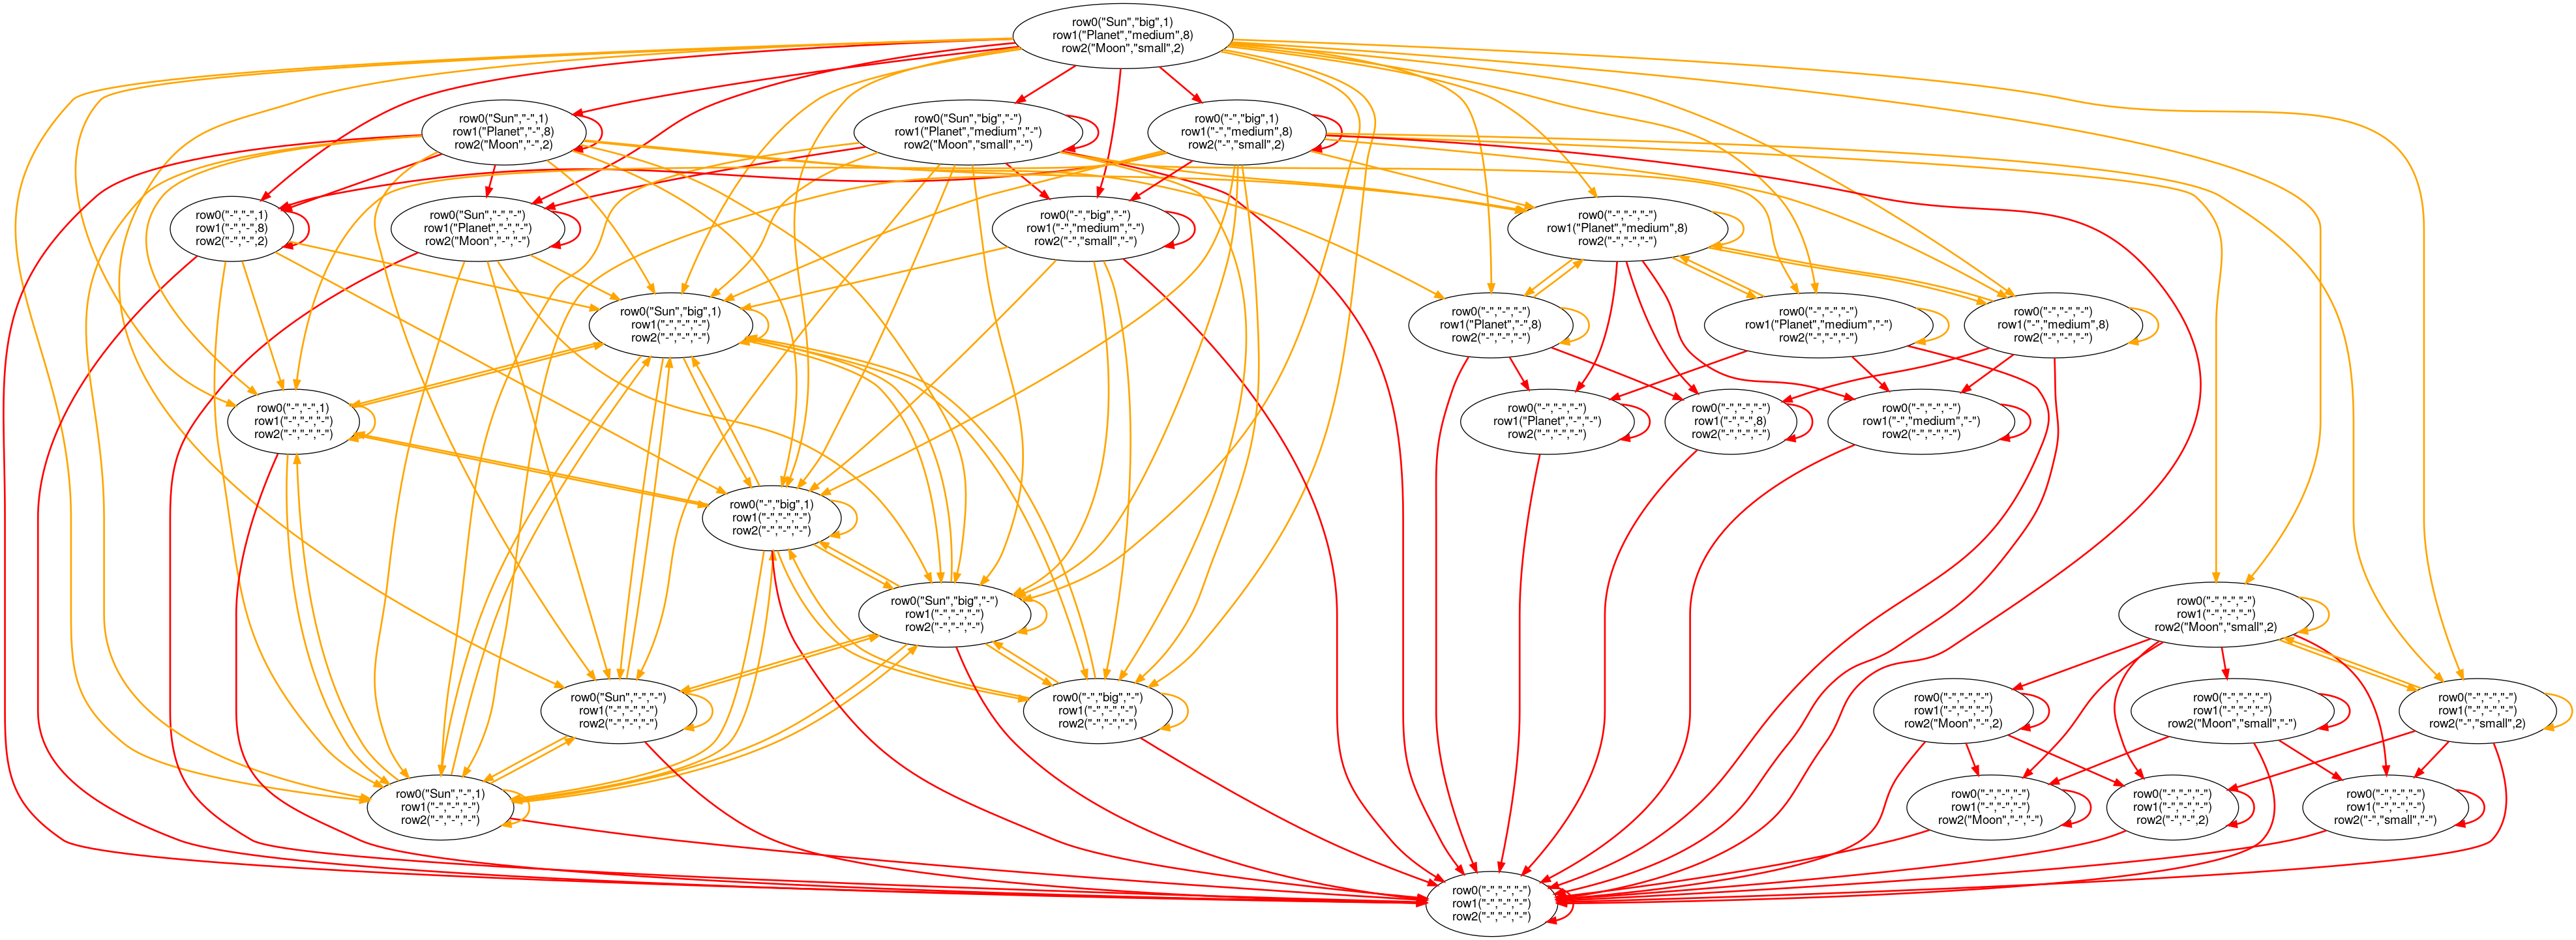

In [30]:
G = nx.DiGraph()

edges = []
start_col_names = ['TYPE','SIZE','POPULATION']
end_col_names = ['ENDTYPE','ENDSIZE','ENDPOPULATION']

startList = []
endList = []

for i, row in pwe_e3_new_format.iterrows():
    start_node = smallConvert(row['dataStart'])
    end_node = smallConvert(row['dataEnd'])
    startList.append(start_node)
    endList.append(end_node)
    colour = transExtract(row)['colour']
    G.add_edge(start_node, end_node, penwidth=2,color=colour)
    edges.append((start_node, end_node))
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
#G.graph['layout'] = 'fdp'
    
draw(G)
    
# G.graph['rankdir'] = 'TB'

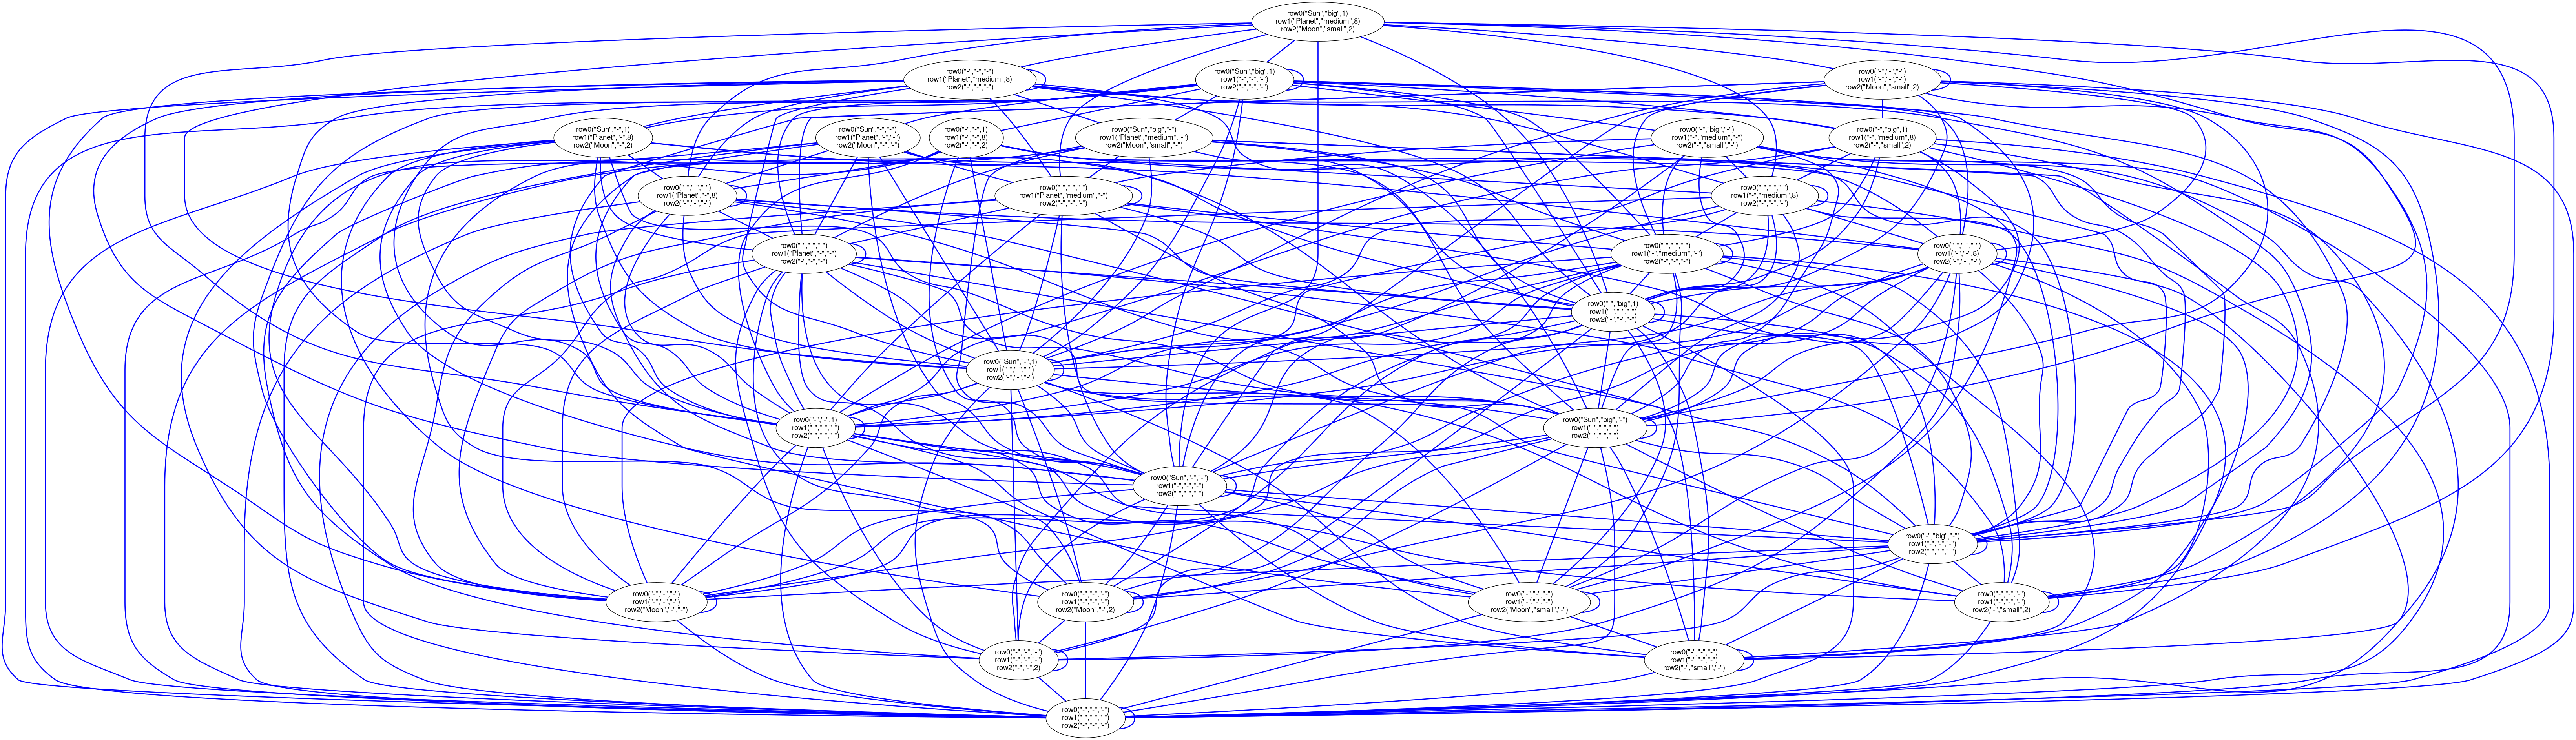

In [40]:
G = nx.Graph()

edges = []
start_col_names = ['TYPE','SIZE','POPULATION']
end_col_names = ['ENDTYPE','ENDSIZE','ENDPOPULATION']

startList = []
endList = []

for i, row in pwe_e3_new_format.iterrows():
    colour = transExtract(row)['colour']
    if colour == 'blue':
        start_node = smallConvert(row['dataStart'])
        end_node = smallConvert(row['dataEnd'])
        startList.append(start_node)
        endList.append(end_node)
        G.add_edge(start_node, end_node, penwidth=2,color=colour)
        edges.append((start_node, end_node))
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
#G.graph['layout'] = 'fdp'
    
draw(G)
    
# G.graph['rankdir'] = 'TB'

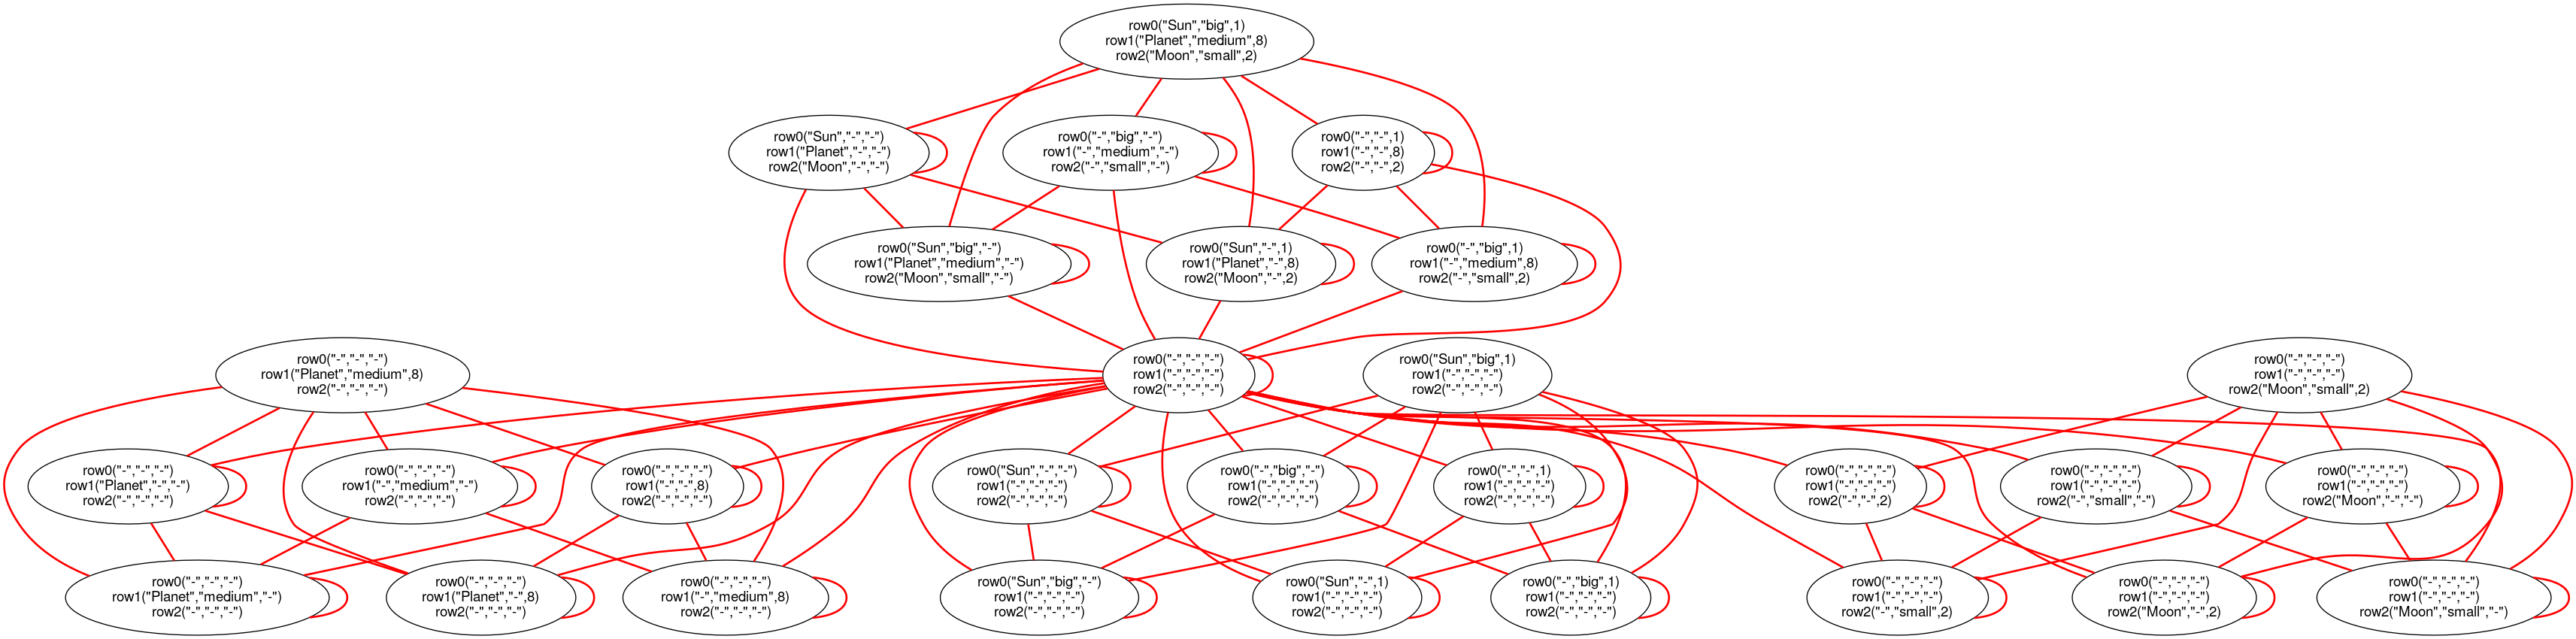

In [41]:
G = nx.Graph()

edges = []
start_col_names = ['TYPE','SIZE','POPULATION']
end_col_names = ['ENDTYPE','ENDSIZE','ENDPOPULATION']

startList = []
endList = []

for i, row in pwe_e3_new_format.iterrows():
    colour = transExtract(row)['colour']
    if colour == 'red':
        start_node = smallConvert(row['dataStart'])
        end_node = smallConvert(row['dataEnd'])
        startList.append(start_node)
        endList.append(end_node)
        G.add_edge(start_node, end_node, penwidth=2,color=colour)
        edges.append((start_node, end_node))
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
#G.graph['layout'] = 'fdp'
    
draw(G)
    
# G.graph['rankdir'] = 'TB'

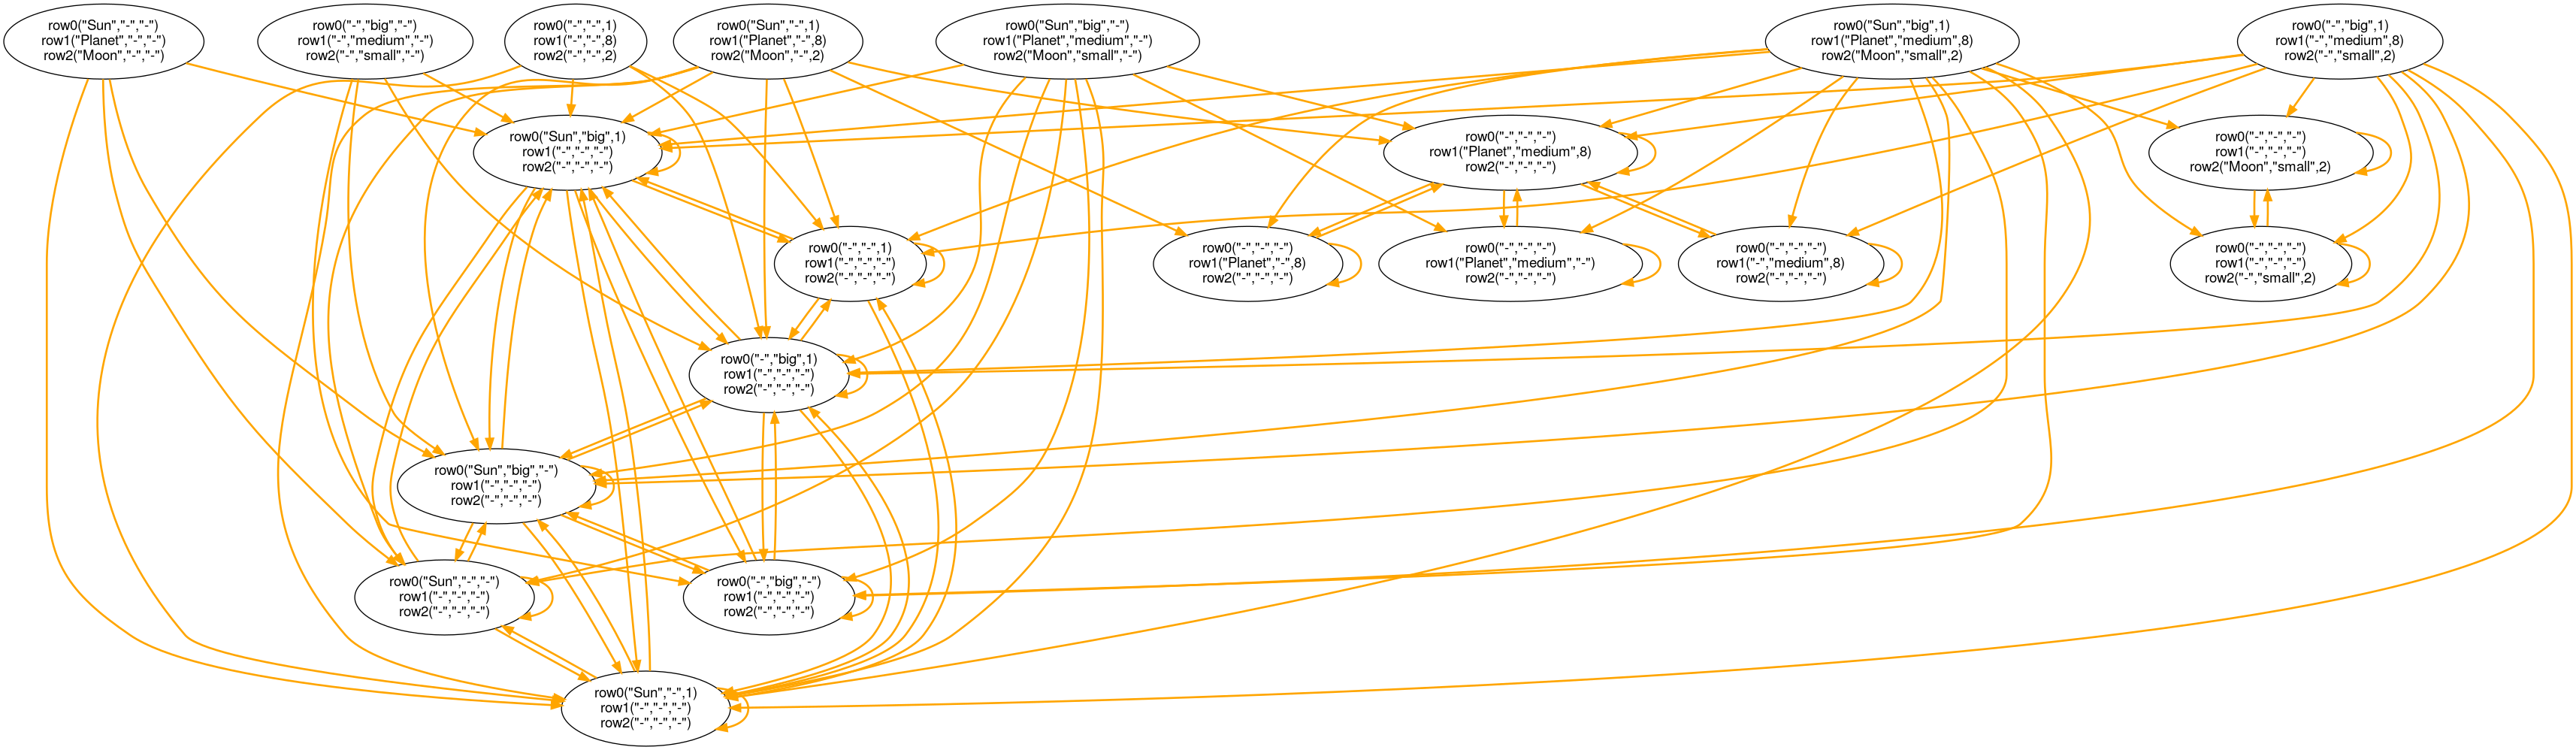

In [51]:
G = nx.DiGraph()

edges = []
start_col_names = ['TYPE','SIZE','POPULATION']
end_col_names = ['ENDTYPE','ENDSIZE','ENDPOPULATION']

startList = []
endList = []

for i, row in pwe_e3_new_format.iterrows():
    colour = transExtract(row)['colour']
    if colour == 'orange':
        start_node = smallConvert(row['dataStart'])
        end_node = smallConvert(row['dataEnd'])
        startList.append(start_node)
        endList.append(end_node)
        G.add_edge(start_node, end_node, penwidth=2,color=colour)
        edges.append((start_node, end_node))
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
#G.graph['layout'] = 'fdp'
    
draw(G)
    
# G.graph['rankdir'] = 'TB'

In [316]:
def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

#Assuming that the graph g has nodes and edges entered
save_graph(G,"my_graph.pdf")

/home/mj1e16/miniconda2/envs/PWE_explorer/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/mj1e16/miniconda2/envs/PWE_explorer/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


In [52]:
rowNum = 10
target = [pw_rels_dfs[edge_rel_name][colname][rowNum] for colname in end_col_names]
target = '('+','.join(target)+')'

KeyError: 'e3'

In [31]:
target = pwe_e3_new_format['dataEnd'][10]

In [32]:
start = pwe_e3_new_format['dataStart'][0]

In [33]:
target

'data(row0("Sun","big",1),row1("-","-","-"),row2("-","-","-"))'

In [34]:
start

'data(row0("Sun","big",1),row1("Planet","medium",8),row2("Moon","small",2))'

In [35]:
newStart = smallConvert(start)
print(newStart)

row0("Sun","big",1)
row1("Planet","medium",8)
row2("Moon","small",2)


In [36]:
newTarget = smallConvert(target)
print(newTarget)

row0("Sun","big",1)
row1("-","-","-")
row2("-","-","-")


In [37]:
allPaths = []
#for sources in dataValuesNonStr:
singlePath = []
for path in nx.all_simple_paths(G,source=newStart,target=newTarget):
    singlePath.append(path)
allPaths.append(singlePath)

In [38]:
len(allPaths[0])

1741